In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.inspection import permutation_importance
import seaborn as sns

In [ ]:
# Load and preprocess quantum dot data
qd_data = load_and_preprocess_qd_data()
print(f"Generated data for {len(qd_data)} quantum dot compositions")
print(qd_data.head())

# Train and compare ML models
results, X_train, X_test, y_train, y_test, scaler = train_and_compare_models(qd_data)

# Analyze feature importance
feature_names = qd_data.drop(['good_qd', 'composition'], axis=1).columns
importances, perm_importance = analyze_feature_importance(
    results, X_train, X_test, y_train, y_test, feature_names
)

# Visualize decision boundaries
X_train_scaled = scaler.transform(X_train)
visualize_decision_boundaries(results, X_train_scaled, y_train)

# Fixed

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def load_and_preprocess_qd_data(n_samples=200, random_seed=42):
    """Generate synthetic quantum dot perovskite data"""
    np.random.seed(random_seed)
    
    # Create features based on QD properties
    tolerance_factor = np.random.uniform(0.7, 1.1, n_samples)
    bandgap = np.random.uniform(1.5, 3.5, n_samples)
    diameter = np.random.uniform(2, 10, n_samples)
    quantum_yield = np.random.uniform(0, 100, n_samples)
    stability = np.random.uniform(0, 1000, n_samples)
    
    # Create synthetic targets (good QDs vs. poor QDs) based on simple rules
    good_qd = []
    for i in range(n_samples):
        t = tolerance_factor[i]
        bg = bandgap[i]
        qy = quantum_yield[i]
        
        # Rule-based classification with some randomness
        if (0.8 <= t <= 1.0) and (1.8 <= bg <= 3.0) and (qy > 60):
            prob_good = 0.85
        else:
            prob_good = 0.15
        
        good_qd.append(1 if np.random.random() < prob_good else 0)
    
    # Create DataFrame
    df = pd.DataFrame({
        'tolerance_factor': tolerance_factor,
        'bandgap_eV': bandgap,
        'diameter_nm': diameter,
        'quantum_yield': quantum_yield,
        'stability_hours': stability,
        'good_qd': good_qd
    })
    
    return df

def train_qd_classifier(data, n_estimators=100, test_size=0.25):
    """Train random forest classifier on QD data"""
    # Prepare data
    X = data.drop('good_qd', axis=1)
    y = data['good_qd']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Train model
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy:.4f}")
    
    return model, X_train, X_test, y_train, y_test

def plot_feature_importance(model, feature_names):
    """Plot feature importance from the trained model"""
    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importance for Quantum Dot Classification')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix for model evaluation"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Poor QD', 'Good QD'], 
                yticklabels=['Poor QD', 'Good QD'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def visualize_decision_space(model, X_train, y_train, feature1=0, feature2=1):
    """Visualize decision boundaries for two selected features"""
    # Get feature names
    feature_names = X_train.columns
    
    # Convert to numpy arrays
    X = X_train.values
    y = y_train.values
    
    # Create mesh grid
    x_min, x_max = X[:, feature1].min() - 0.1, X[:, feature1].max() + 0.1
    y_min, y_max = X[:, feature2].min() - 0.1, X[:, feature2].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Make prediction on the meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel(), 
                           np.zeros((xx.ravel().shape[0], X.shape[1]-2))])
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    
    # Plot training points
    scatter = plt.scatter(X[:, feature1], X[:, feature2], c=y, 
                         edgecolor='k', s=60, cmap=plt.cm.RdBu)
    
    plt.xlabel(feature_names[feature1])
    plt.ylabel(feature_names[feature2])
    plt.title('Decision Boundary for Quantum Dot Classification')
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

Generated data for quantum dots:
   tolerance_factor  bandgap_eV  diameter_nm  quantum_yield  stability_hours  \
0          0.849816    2.784063     2.824991      16.893506       707.238634   
1          1.080286    1.668280     9.220423      27.859034       152.539043   
2          0.992798    1.823257     6.042019      17.701048       576.288360   
3          0.939463    3.297108     8.611660       8.870253       606.715046   
4          0.762407    2.712858     4.560397      12.063587       424.130671   

   good_qd  
0        0  
1        0  
2        0  
3        0  
4        0  
Model accuracy: 0.7200


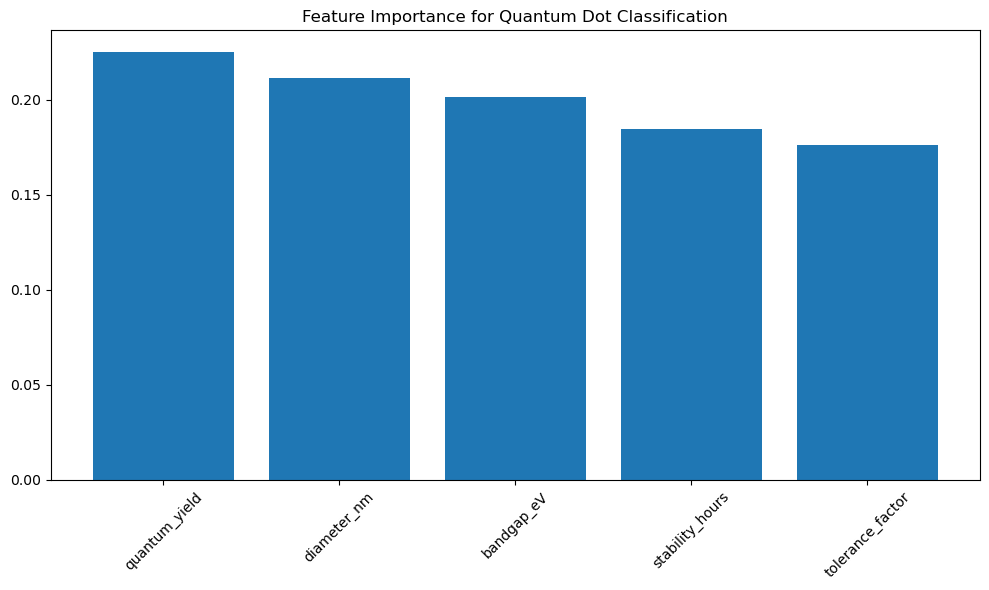

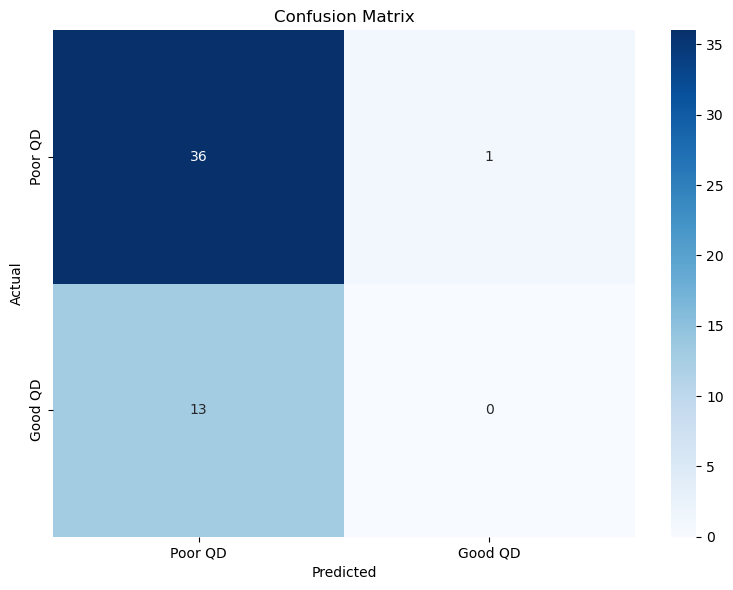

/gpfs/home/gdb20/.conda/envs/CHM4411L/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


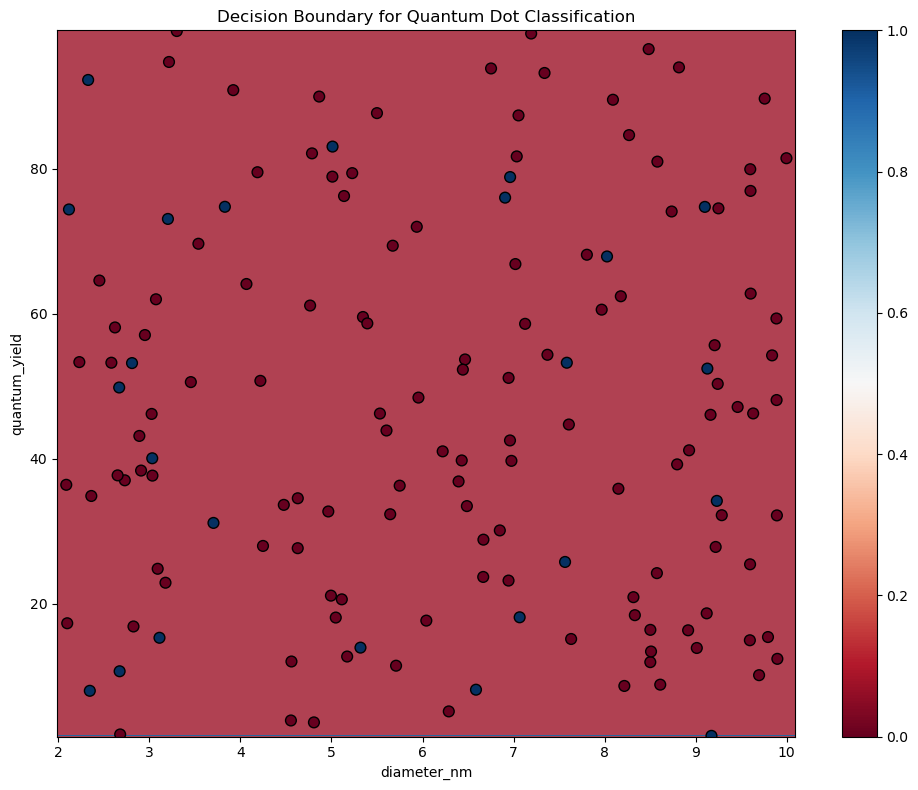

In [7]:
# Generate synthetic quantum dot data
qd_data = load_and_preprocess_qd_data(n_samples=200)
print("Generated data for quantum dots:")
print(qd_data.head())

# Train a random forest classifier
model, X_train, X_test, y_train, y_test = train_qd_classifier(qd_data)

# Plot feature importance
plot_feature_importance(model, X_train.columns)

# Evaluate model with confusion matrix
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

# Visualize decision space for two important features
visualize_decision_space(model, X_train, y_train, 
                        feature1=2, feature2=3)  # Diameter vs Quantum Yield

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def generate_qd_data(n_samples=200, random_seed=42):
    """Generate synthetic quantum dot data as numpy arrays"""
    np.random.seed(random_seed)
    
    # Create features based on QD properties
    tolerance_factor = np.random.uniform(0.7, 1.1, n_samples)
    bandgap = np.random.uniform(1.5, 3.5, n_samples)
    diameter = np.random.uniform(2, 10, n_samples)
    quantum_yield = np.random.uniform(0, 100, n_samples)
    stability = np.random.uniform(0, 1000, n_samples)
    
    # Combine features into X matrix
    X = np.column_stack([tolerance_factor, bandgap, diameter, quantum_yield, stability])
    
    # Create synthetic targets (good QDs vs. poor QDs) based on simple rules
    y = np.zeros(n_samples)
    for i in range(n_samples):
        t = tolerance_factor[i]
        bg = bandgap[i]
        qy = quantum_yield[i]
        
        # Rule-based classification with some randomness
        if (0.8 <= t <= 1.0) and (1.8 <= bg <= 3.0) and (qy > 60):
            prob_good = 0.85
        else:
            prob_good = 0.15
        
        y[i] = 1 if np.random.random() < prob_good else 0
    
    # Feature names (for display only)
    feature_names = ['Tolerance Factor', 'Bandgap (eV)', 
                     'Diameter (nm)', 'Quantum Yield (%)', 
                     'Stability (hours)']
    
    return X, y, feature_names

def train_model_and_plot(n_samples=200):
    """Generate data, train model, and create visualizations"""
    # Generate data
    X, y, feature_names = generate_qd_data(n_samples)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy:.4f}")
    
    # Set up the figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Feature Importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    axes[0].bar(range(len(importances)), importances[indices], align='center')
    axes[0].set_xticks(range(len(importances)))
    axes[0].set_xticklabels([feature_names[i] for i in indices], rotation=45)
    axes[0].set_title('Feature Importance')
    axes[0].set_ylabel('Importance Score')
    
    # Plot 2: Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                xticklabels=['Poor QD', 'Good QD'], 
                yticklabels=['Poor QD', 'Good QD'])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_title('Confusion Matrix')
    
    # Plot 3: Scatter plot of two most important features
    top_features = indices[:2]
    feature1, feature2 = top_features[0], top_features[1]
    
    scatter = axes[2].scatter(X_train[:, feature1], X_train[:, feature2], 
                             c=y_train, edgecolor='k', s=60, cmap='coolwarm')
    
    axes[2].set_xlabel(feature_names[feature1])
    axes[2].set_ylabel(feature_names[feature2])
    axes[2].set_title('Top Features Distribution')
    
    legend1 = axes[2].legend(*scatter.legend_elements(),
                            loc="upper right", title="QD Quality")
    axes[2].add_artist(legend1)
    
    plt.tight_layout()
    plt.show()
    
    return model, X, y, feature_names

Model accuracy: 0.7200


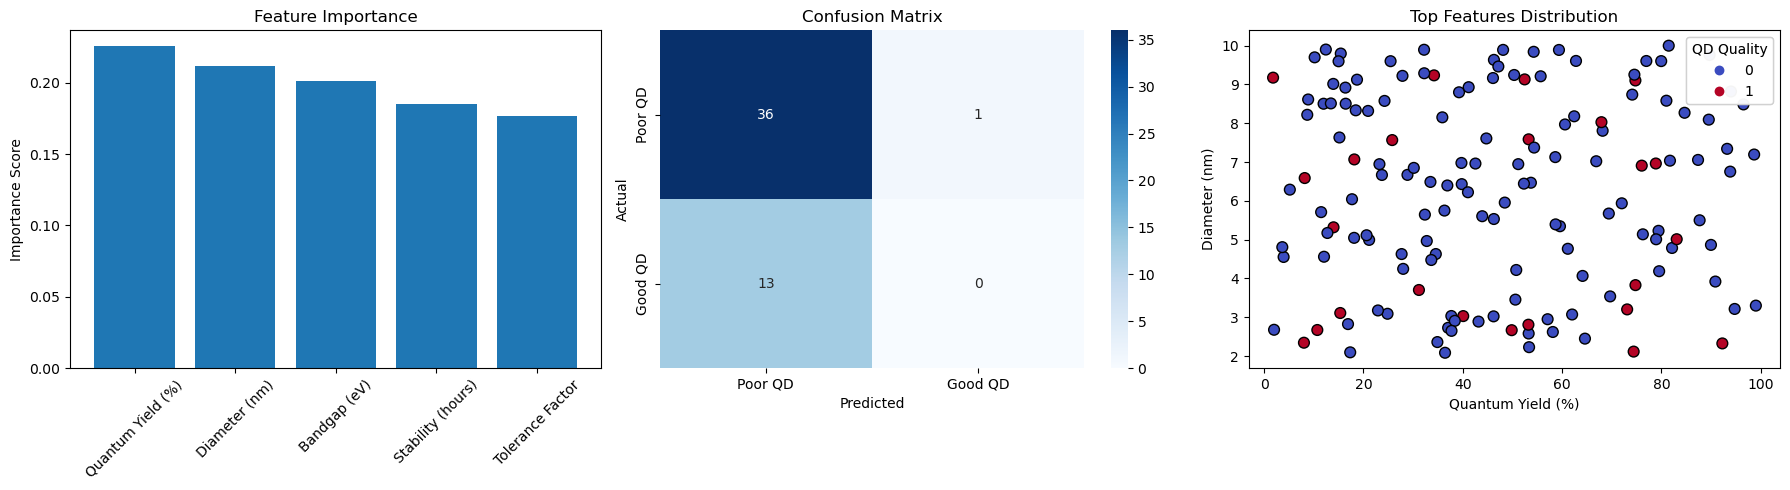

In [8]:
# Train model and generate all visualizations
model, X, y, feature_names = train_model_and_plot(n_samples=200)

Model accuracy: 0.7000


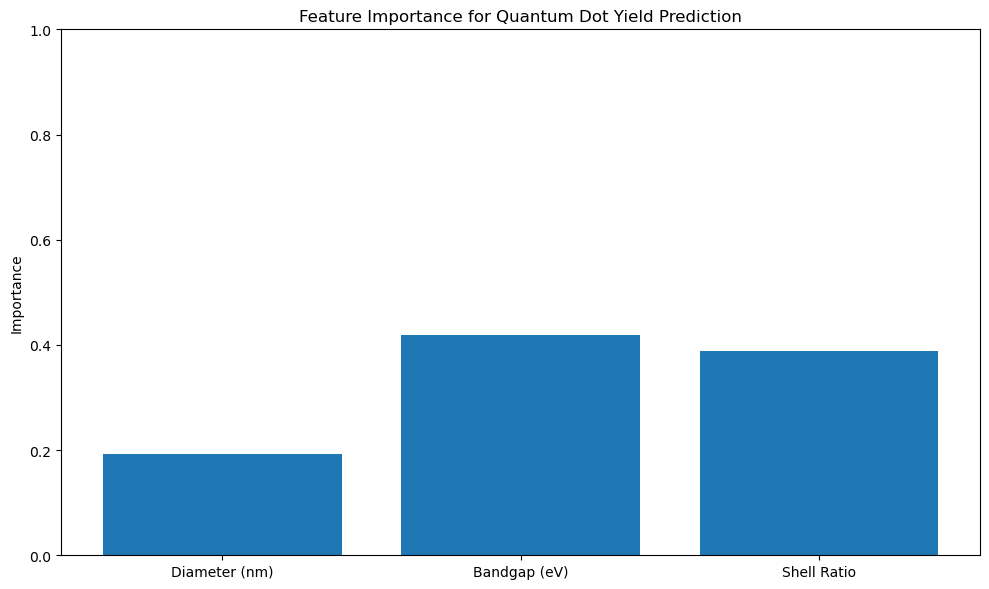

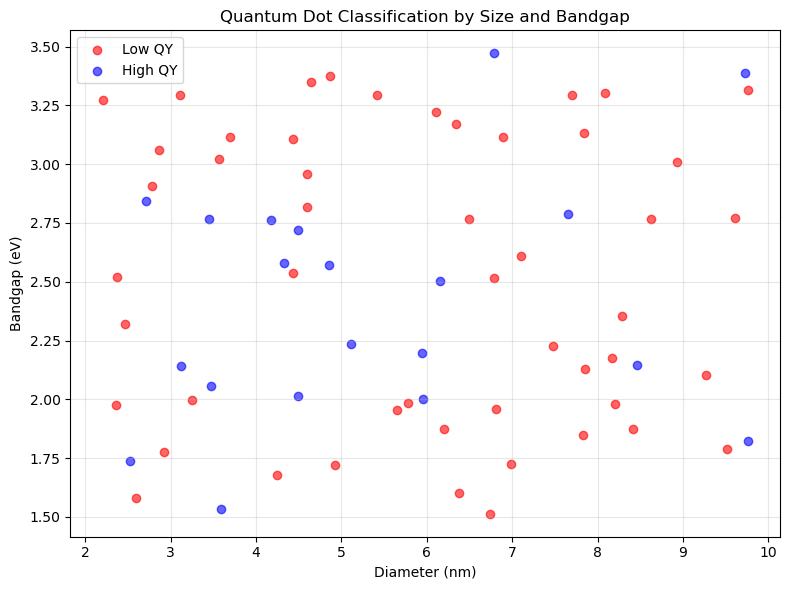

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

def simple_qd_classification():
    """
    Simple quantum dot classification with only 3 features:
    - Size (diameter in nm)
    - Bandgap (eV)
    - Core/shell thickness ratio
    """
    # Generate synthetic data
    np.random.seed(42)
    n_samples = 100
    
    # Create just 3 features
    size = np.random.uniform(2, 10, n_samples)           # Diameter in nm
    bandgap = np.random.uniform(1.5, 3.5, n_samples)     # Bandgap in eV
    shell_ratio = np.random.uniform(0, 0.5, n_samples)   # Core/shell thickness ratio
    
    # Combine features
    X = np.column_stack([size, bandgap, shell_ratio])
    
    # Generate target: good quantum yield (>50%) = 1, otherwise = 0
    # Rule: smaller QDs with right bandgap and thicker shells tend to have better QY
    y = np.zeros(n_samples)
    for i in range(n_samples):
        # Simple rule: good QY if size is moderate, bandgap is in optimal range, and shell is thick
        if (3 <= size[i] <= 6) and (2.0 <= bandgap[i] <= 3.0) and (shell_ratio[i] > 0.2):
            y[i] = 1
        # Add some randomness
        if np.random.random() < 0.15:  # 15% noise
            y[i] = 1 - y[i]  # Flip the classification
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train a simple random forest
    model = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy:.4f}")
    
    # Feature importance
    feature_names = ['Diameter (nm)', 'Bandgap (eV)', 'Shell Ratio']
    importances = model.feature_importances_
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, importances)
    plt.title('Feature Importance for Quantum Dot Yield Prediction')
    plt.ylabel('Importance')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Plot training data colored by class
    plt.figure(figsize=(8, 6))
    colors = ['red', 'blue']
    labels = ['Low QY', 'High QY']
    for i in range(2):
        idx = y_train == i
        plt.scatter(X_train[idx, 0], X_train[idx, 1], c=colors[i], label=labels[i], alpha=0.6)
    
    plt.xlabel('Diameter (nm)')
    plt.ylabel('Bandgap (eV)')
    plt.title('Quantum Dot Classification by Size and Bandgap')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return model, X, y, feature_names

# Run the simple classification
model, X, y, feature_names = simple_qd_classification()

Model accuracy: 0.7000


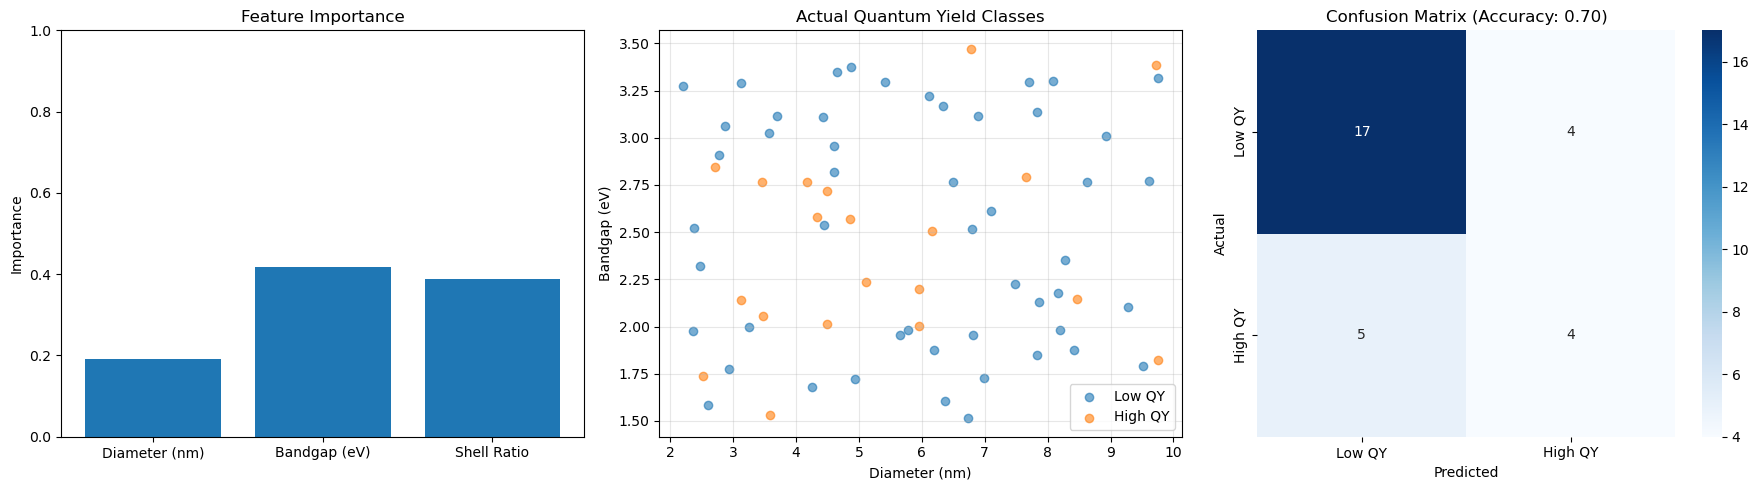

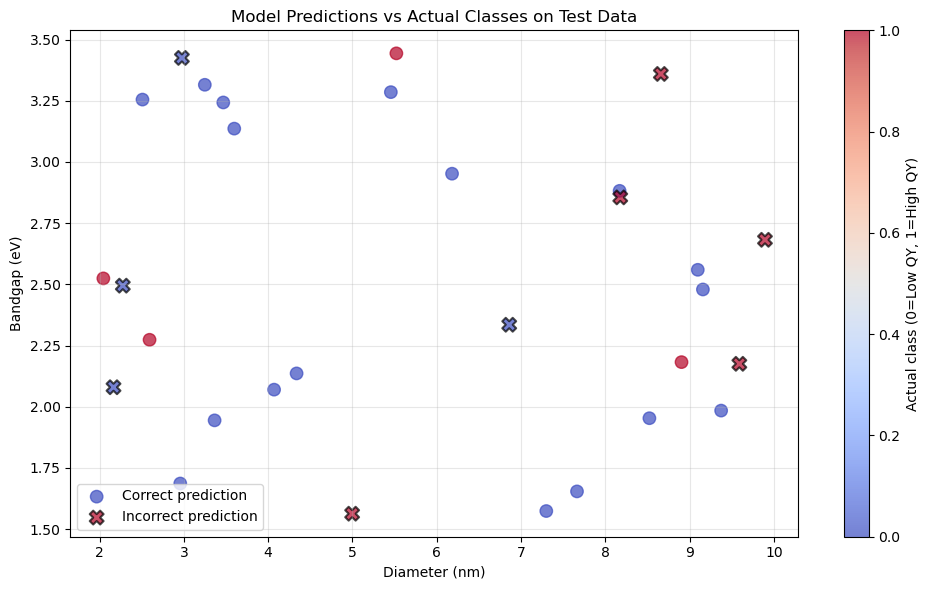

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def simple_qd_classification():
    """
    Simple quantum dot classification with only 3 features:
    - Size (diameter in nm)
    - Bandgap (eV)
    - Core/shell thickness ratio
    """
    # Generate synthetic data
    np.random.seed(42)
    n_samples = 100
    
    # Create just 3 features
    size = np.random.uniform(2, 10, n_samples)           # Diameter in nm
    bandgap = np.random.uniform(1.5, 3.5, n_samples)     # Bandgap in eV
    shell_ratio = np.random.uniform(0, 0.5, n_samples)   # Core/shell thickness ratio
    
    # Combine features
    X = np.column_stack([size, bandgap, shell_ratio])
    
    # Generate target: good quantum yield (>50%) = 1, otherwise = 0
    # Rule: smaller QDs with right bandgap and thicker shells tend to have better QY
    y = np.zeros(n_samples)
    for i in range(n_samples):
        # Simple rule: good QY if size is moderate, bandgap is in optimal range, and shell is thick
        if (3 <= size[i] <= 6) and (2.0 <= bandgap[i] <= 3.0) and (shell_ratio[i] > 0.2):
            y[i] = 1
        # Add some randomness
        if np.random.random() < 0.15:  # 15% noise
            y[i] = 1 - y[i]  # Flip the classification
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train a simple random forest
    model = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy:.4f}")
    
    # Feature importance
    feature_names = ['Diameter (nm)', 'Bandgap (eV)', 'Shell Ratio']
    importances = model.feature_importances_
    
    # Create a figure with 3 subplots for full evaluation
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Feature importance
    axes[0].bar(feature_names, importances)
    axes[0].set_title('Feature Importance')
    axes[0].set_ylabel('Importance')
    axes[0].set_ylim(0, 1)
    
    # Plot 2: Training data with actual class
    for i in range(2):
        idx = y_train == i
        axes[1].scatter(X_train[idx, 0], X_train[idx, 1], 
                      label=f"{'High' if i else 'Low'} QY", alpha=0.6)
    axes[1].set_xlabel('Diameter (nm)')
    axes[1].set_ylabel('Bandgap (eV)')
    axes[1].set_title('Actual Quantum Yield Classes')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Confusion matrix to evaluate model
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
                xticklabels=['Low QY', 'High QY'], 
                yticklabels=['Low QY', 'High QY'])
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')
    axes[2].set_title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot showing test data with predictions
    plt.figure(figsize=(10, 6))
    
    # Plot test points with their predicted classes
    correct = y_test == y_pred
    
    # Correct predictions
    plt.scatter(X_test[correct, 0], X_test[correct, 1], 
               c=y_test[correct], cmap='coolwarm', marker='o', s=80, 
               label='Correct prediction', alpha=0.7)
    
    # Incorrect predictions
    plt.scatter(X_test[~correct, 0], X_test[~correct, 1], 
               c=y_test[~correct], cmap='coolwarm', marker='X', s=100, 
               edgecolors='black', linewidth=1.5,
               label='Incorrect prediction', alpha=0.7)
    
    plt.colorbar(label='Actual class (0=Low QY, 1=High QY)')
    plt.xlabel('Diameter (nm)')
    plt.ylabel('Bandgap (eV)')
    plt.title('Model Predictions vs Actual Classes on Test Data')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return model, X, y, feature_names

# Run the simple classification
model, X, y, feature_names = simple_qd_classification()

Model accuracy: 0.7000


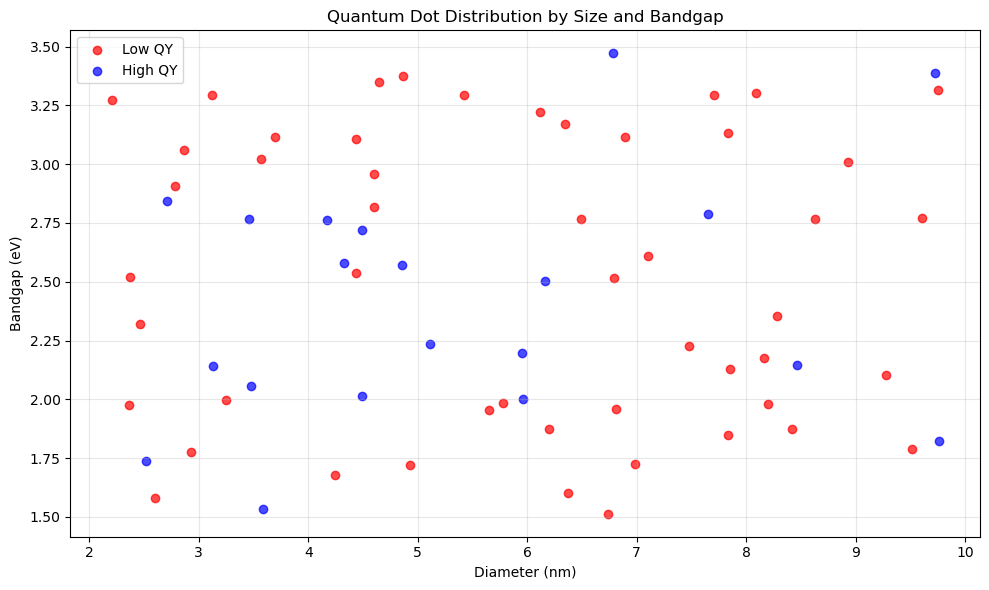

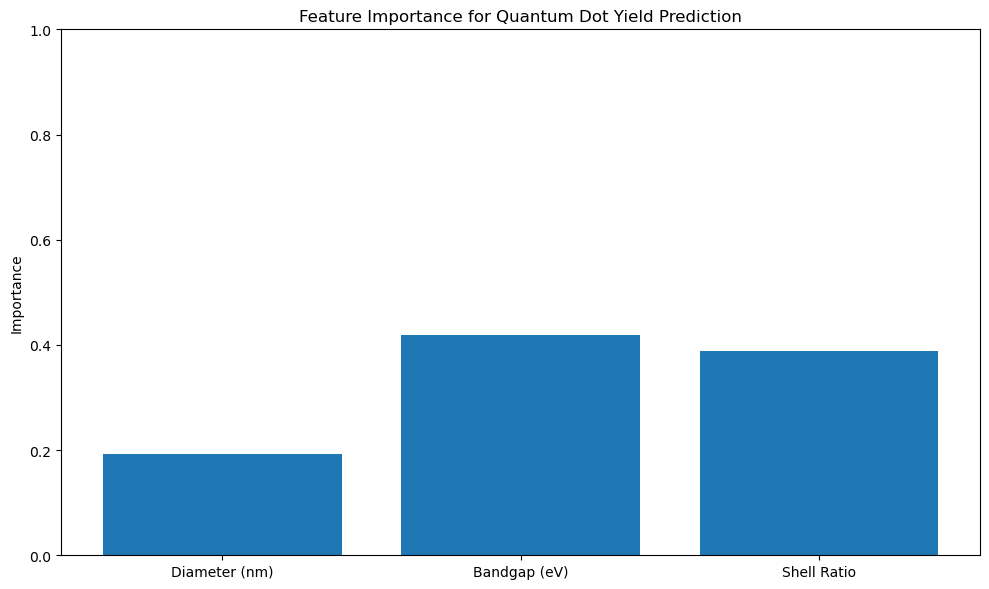

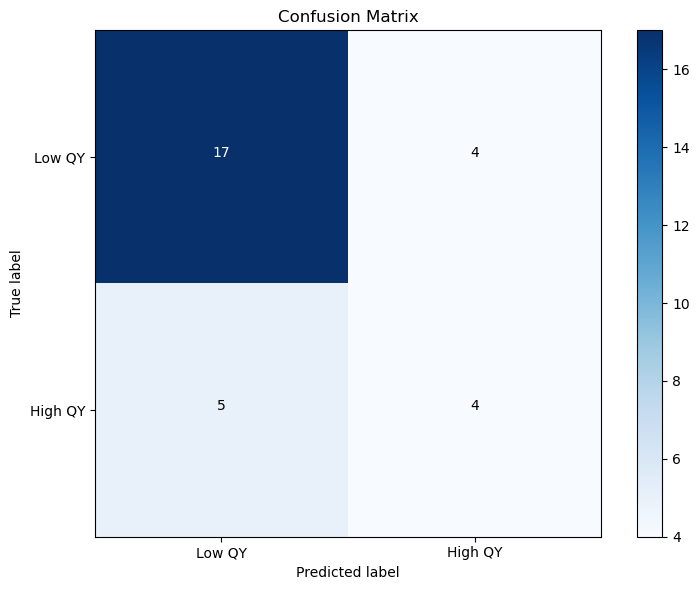

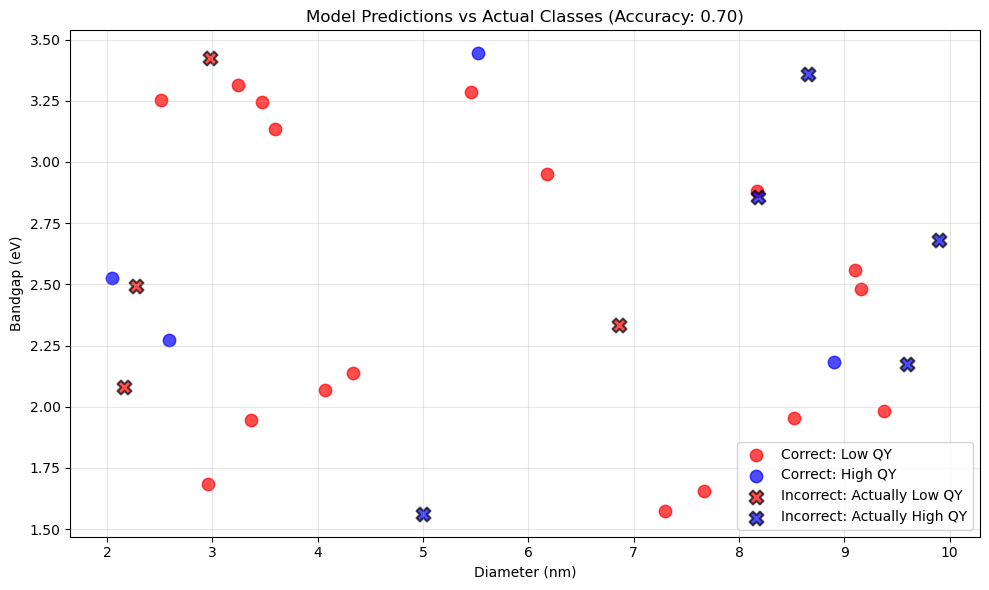

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

def simple_qd_classification():
    """
    Simple quantum dot classification with only 3 features:
    - Size (diameter in nm)
    - Bandgap (eV)
    - Core/shell thickness ratio
    """
    # Generate synthetic data
    np.random.seed(42)
    n_samples = 100
    
    # Create just 3 features
    size = np.random.uniform(2, 10, n_samples)           # Diameter in nm
    bandgap = np.random.uniform(1.5, 3.5, n_samples)     # Bandgap in eV
    shell_ratio = np.random.uniform(0, 0.5, n_samples)   # Core/shell thickness ratio
    
    # Combine features
    X = np.column_stack([size, bandgap, shell_ratio])
    
    # Generate target: good quantum yield (>50%) = 1, otherwise = 0
    # Rule: smaller QDs with right bandgap and thicker shells tend to have better QY
    y = np.zeros(n_samples)
    for i in range(n_samples):
        # Simple rule: good QY if size is moderate, bandgap is in optimal range, and shell is thick
        if (3 <= size[i] <= 6) and (2.0 <= bandgap[i] <= 3.0) and (shell_ratio[i] > 0.2):
            y[i] = 1
        # Add some randomness
        if np.random.random() < 0.15:  # 15% noise
            y[i] = 1 - y[i]  # Flip the classification
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train a simple random forest
    model = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy:.4f}")
    
    # Feature names for display
    feature_names = ['Diameter (nm)', 'Bandgap (eV)', 'Shell Ratio']
    
    # PLOT 1: Actual data distribution
    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue']
    labels = ['Low QY', 'High QY']
    
    for i in range(2):
        idx = y_train == i
        plt.scatter(X_train[idx, 0], X_train[idx, 1], c=colors[i], label=labels[i], alpha=0.7)
    
    plt.xlabel('Diameter (nm)')
    plt.ylabel('Bandgap (eV)')
    plt.title('Quantum Dot Distribution by Size and Bandgap')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # PLOT 2: Feature importance
    importances = model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, importances)
    plt.title('Feature Importance for Quantum Dot Yield Prediction')
    plt.ylabel('Importance')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # PLOT 3: Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['Low QY', 'High QY'])
    plt.yticks(tick_marks, ['Low QY', 'High QY'])
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # PLOT 4: Predictions vs actual on test data
    plt.figure(figsize=(10, 6))
    
    # Plot test points with their predicted classes
    correct = y_test == y_pred
    
    # Correct predictions
    plt.scatter(X_test[correct & (y_test == 0), 0], X_test[correct & (y_test == 0), 1], 
               color='red', marker='o', s=80, label='Correct: Low QY', alpha=0.7)
    plt.scatter(X_test[correct & (y_test == 1), 0], X_test[correct & (y_test == 1), 1], 
               color='blue', marker='o', s=80, label='Correct: High QY', alpha=0.7)
    
    # Incorrect predictions
    plt.scatter(X_test[~correct & (y_test == 0), 0], X_test[~correct & (y_test == 0), 1], 
               color='red', marker='X', s=100, edgecolors='black', linewidth=1.5,
               label='Incorrect: Actually Low QY', alpha=0.7)
    plt.scatter(X_test[~correct & (y_test == 1), 0], X_test[~correct & (y_test == 1), 1], 
               color='blue', marker='X', s=100, edgecolors='black', linewidth=1.5,
               label='Incorrect: Actually High QY', alpha=0.7)
    
    plt.xlabel('Diameter (nm)')
    plt.ylabel('Bandgap (eV)')
    plt.title(f'Model Predictions vs Actual Classes (Accuracy: {accuracy:.2f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return model, X, y, feature_names

# Run the simple classification
model, X, y, feature_names = simple_qd_classification()